In [190]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib as mpl

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from itertools import product

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Идеи для фич

1) лаги/средние/...
2) курс доллара
3) дата налогового дня?
4) праздники
5) время отдыха
6) ...

# Загрузка данных

In [191]:
df = pd.read_excel("/home/owner/Documents/DEV/Time_series/Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date')

In [192]:
df.index.dtype

dtype('<M8[ns]')

# График временного ряда

<Axes: xlabel='Date', ylabel='Balance'>

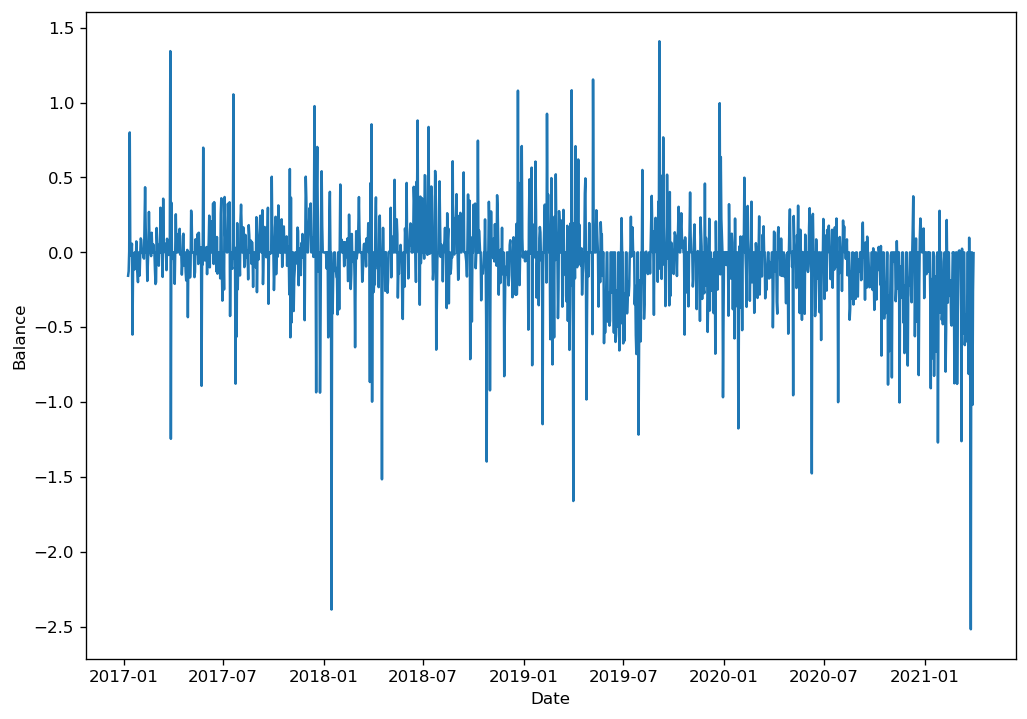

In [193]:
sns.lineplot(x = df.index, y = df.Balance)


# Тест Дики-Фуллера для проверки на стационарность

In [194]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [195]:
adf_test(df.Balance)

Results of Dickey-Fuller Test:
Test Statistic                   -4.114101
p-value                           0.000918
#Lags Used                       20.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
dtype: float64


In [196]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [197]:
check_stationarity(df.Balance)

ADF Statistic: -4.114101
p-value: 0.000918
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


# Разложение на компоненты (попытка)

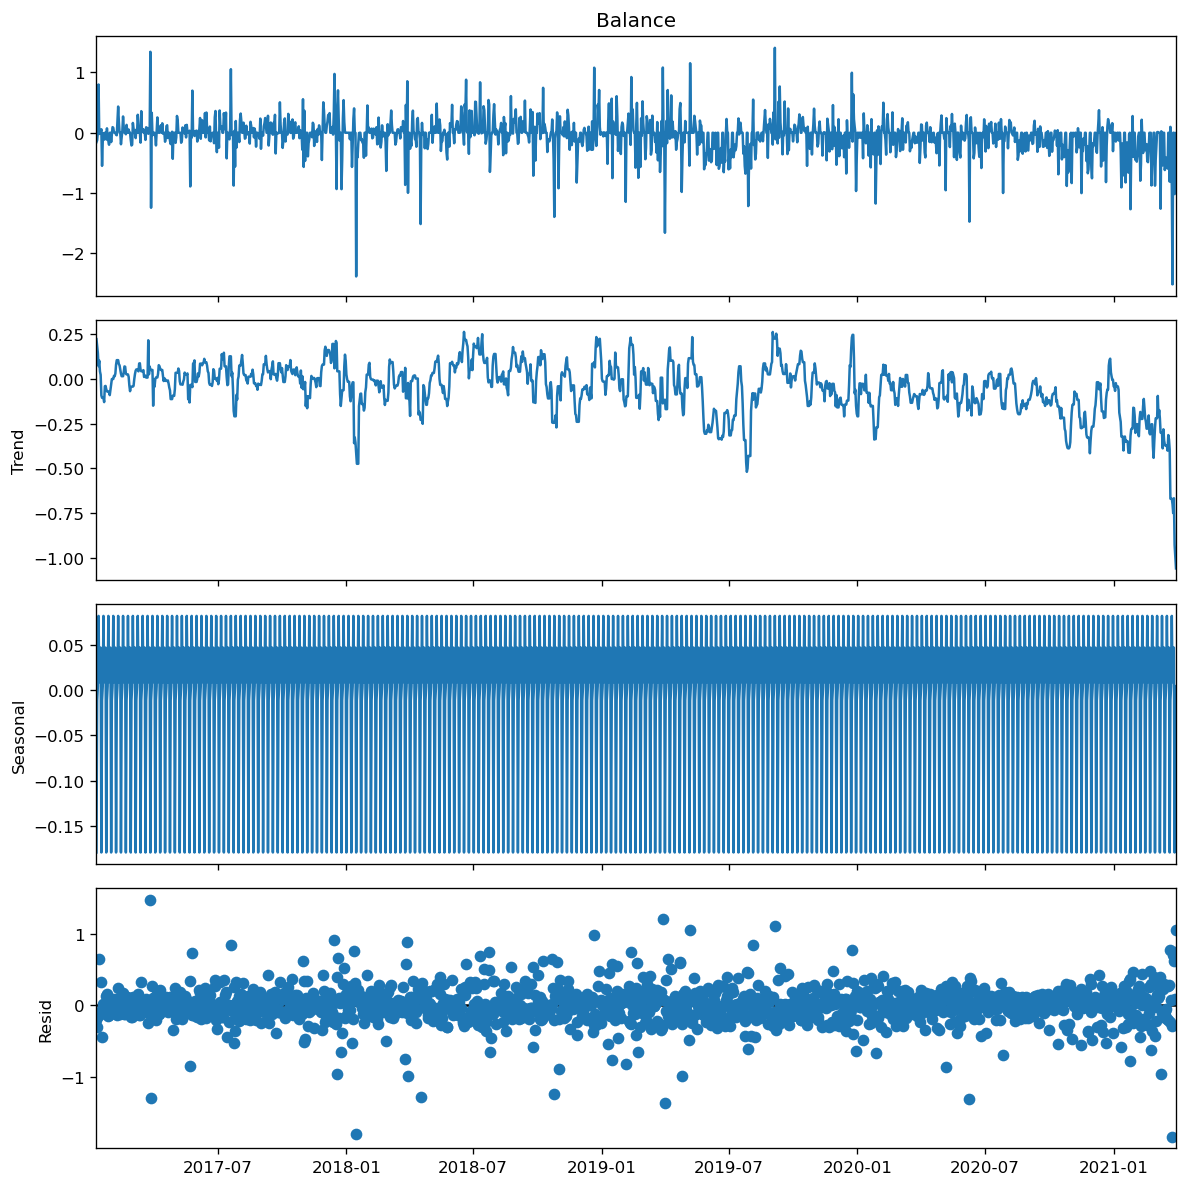

In [198]:
# Additive Decomposition
result_add = seasonal_decompose(df.Balance, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

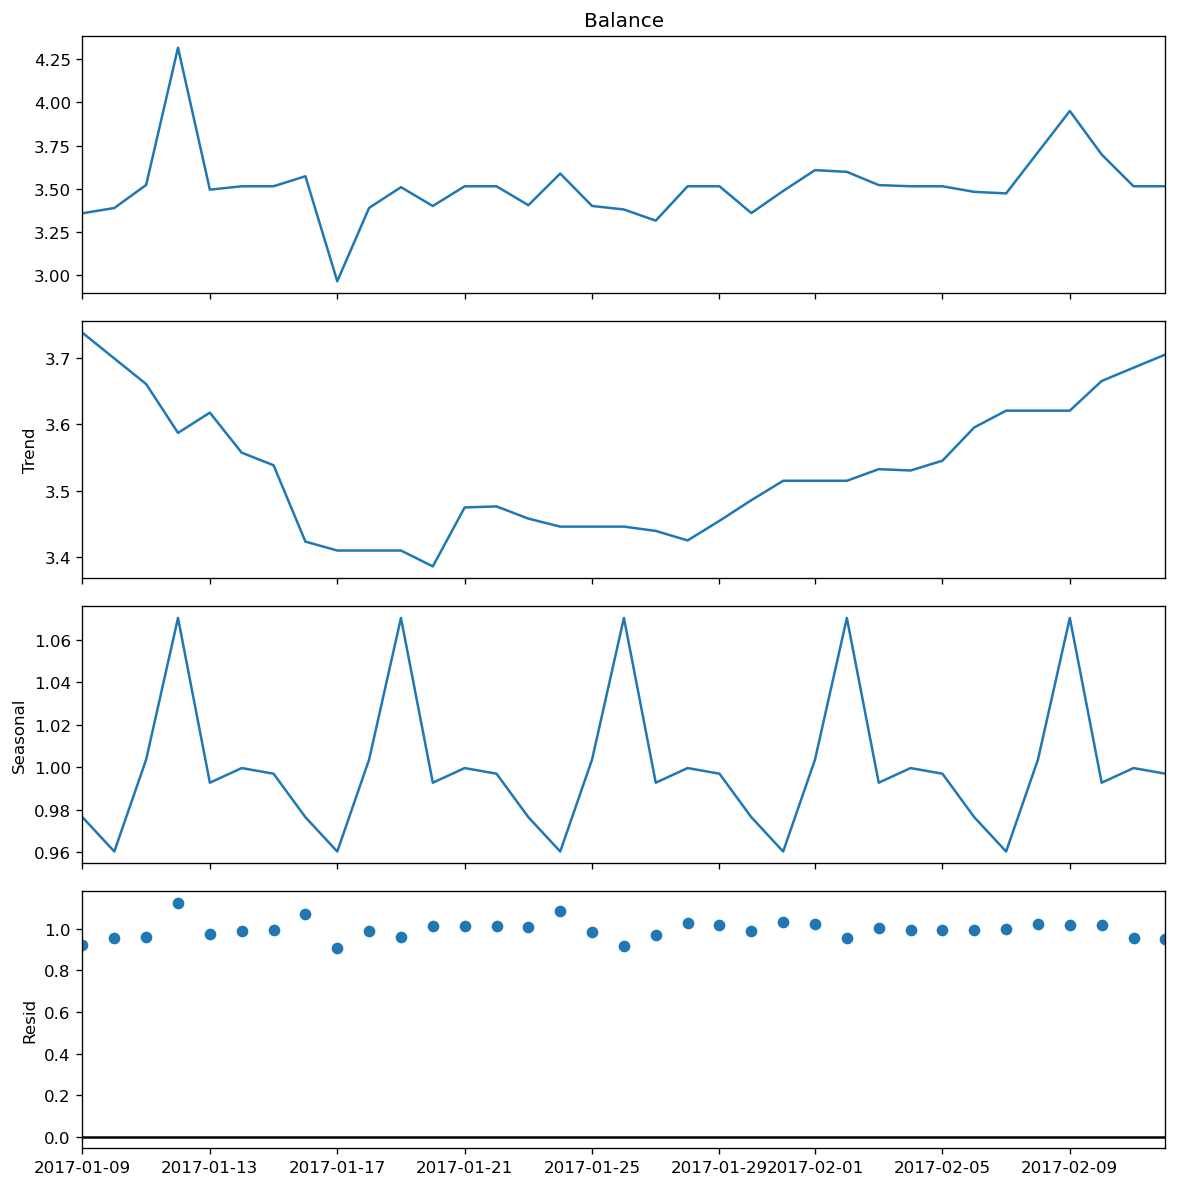

In [199]:
df.posBalance = df.Balance + np.abs(df.Balance.min()) + 1

result_add = seasonal_decompose(df.posBalance[:35], model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

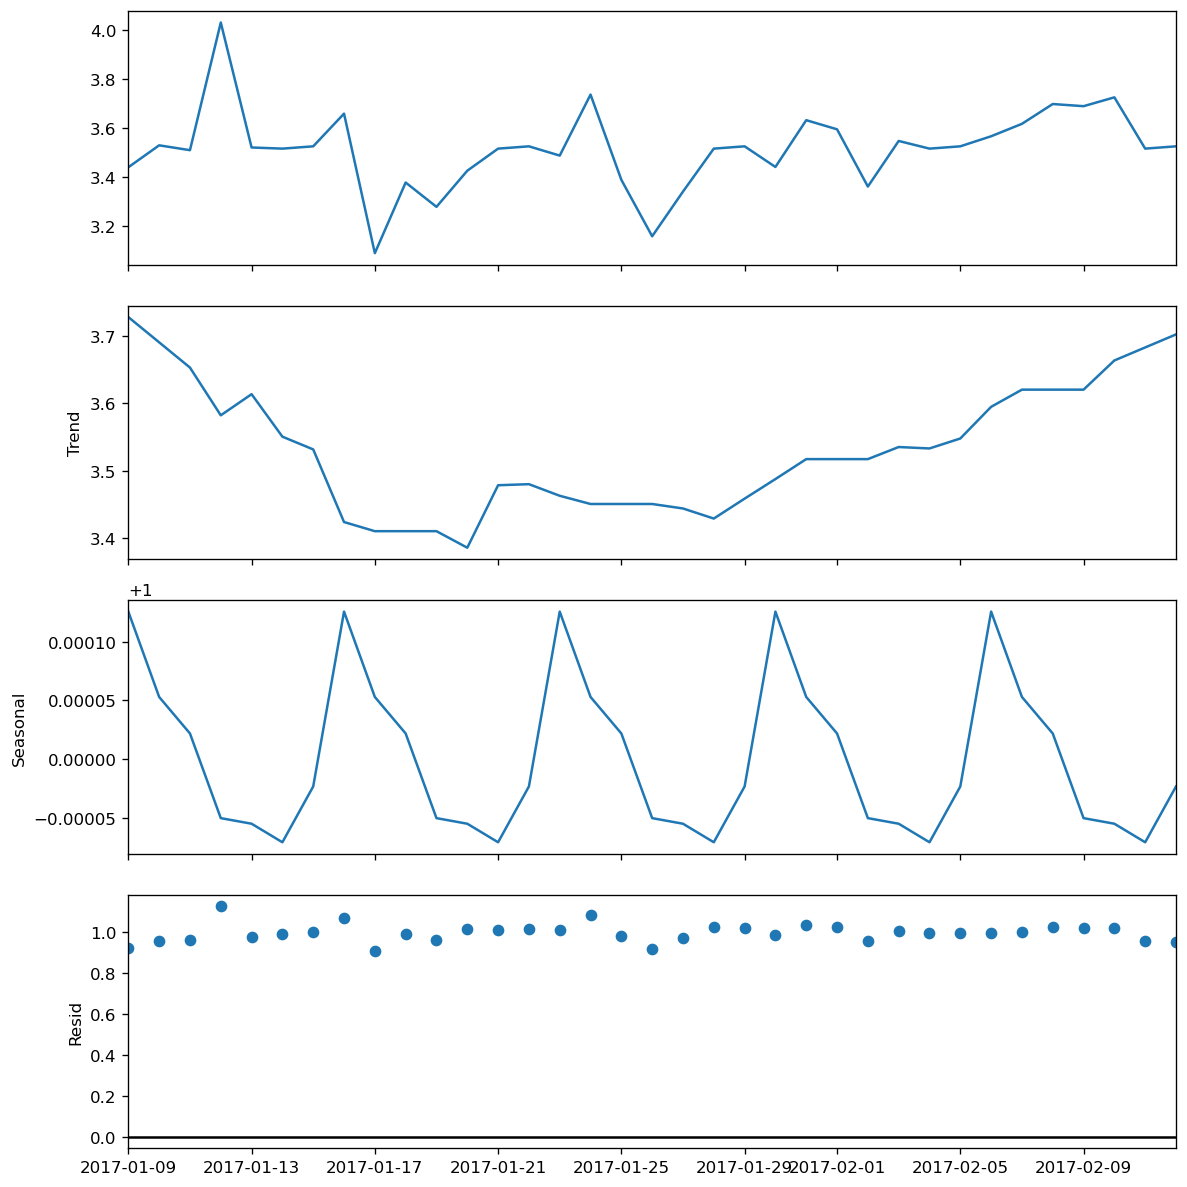

In [200]:
result_add.seasonal

result_add = seasonal_decompose(df.posBalance[:35] / result_add.seasonal, model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

# Стабилизация Дисперсии (?)

# Изучение ACF/PACF

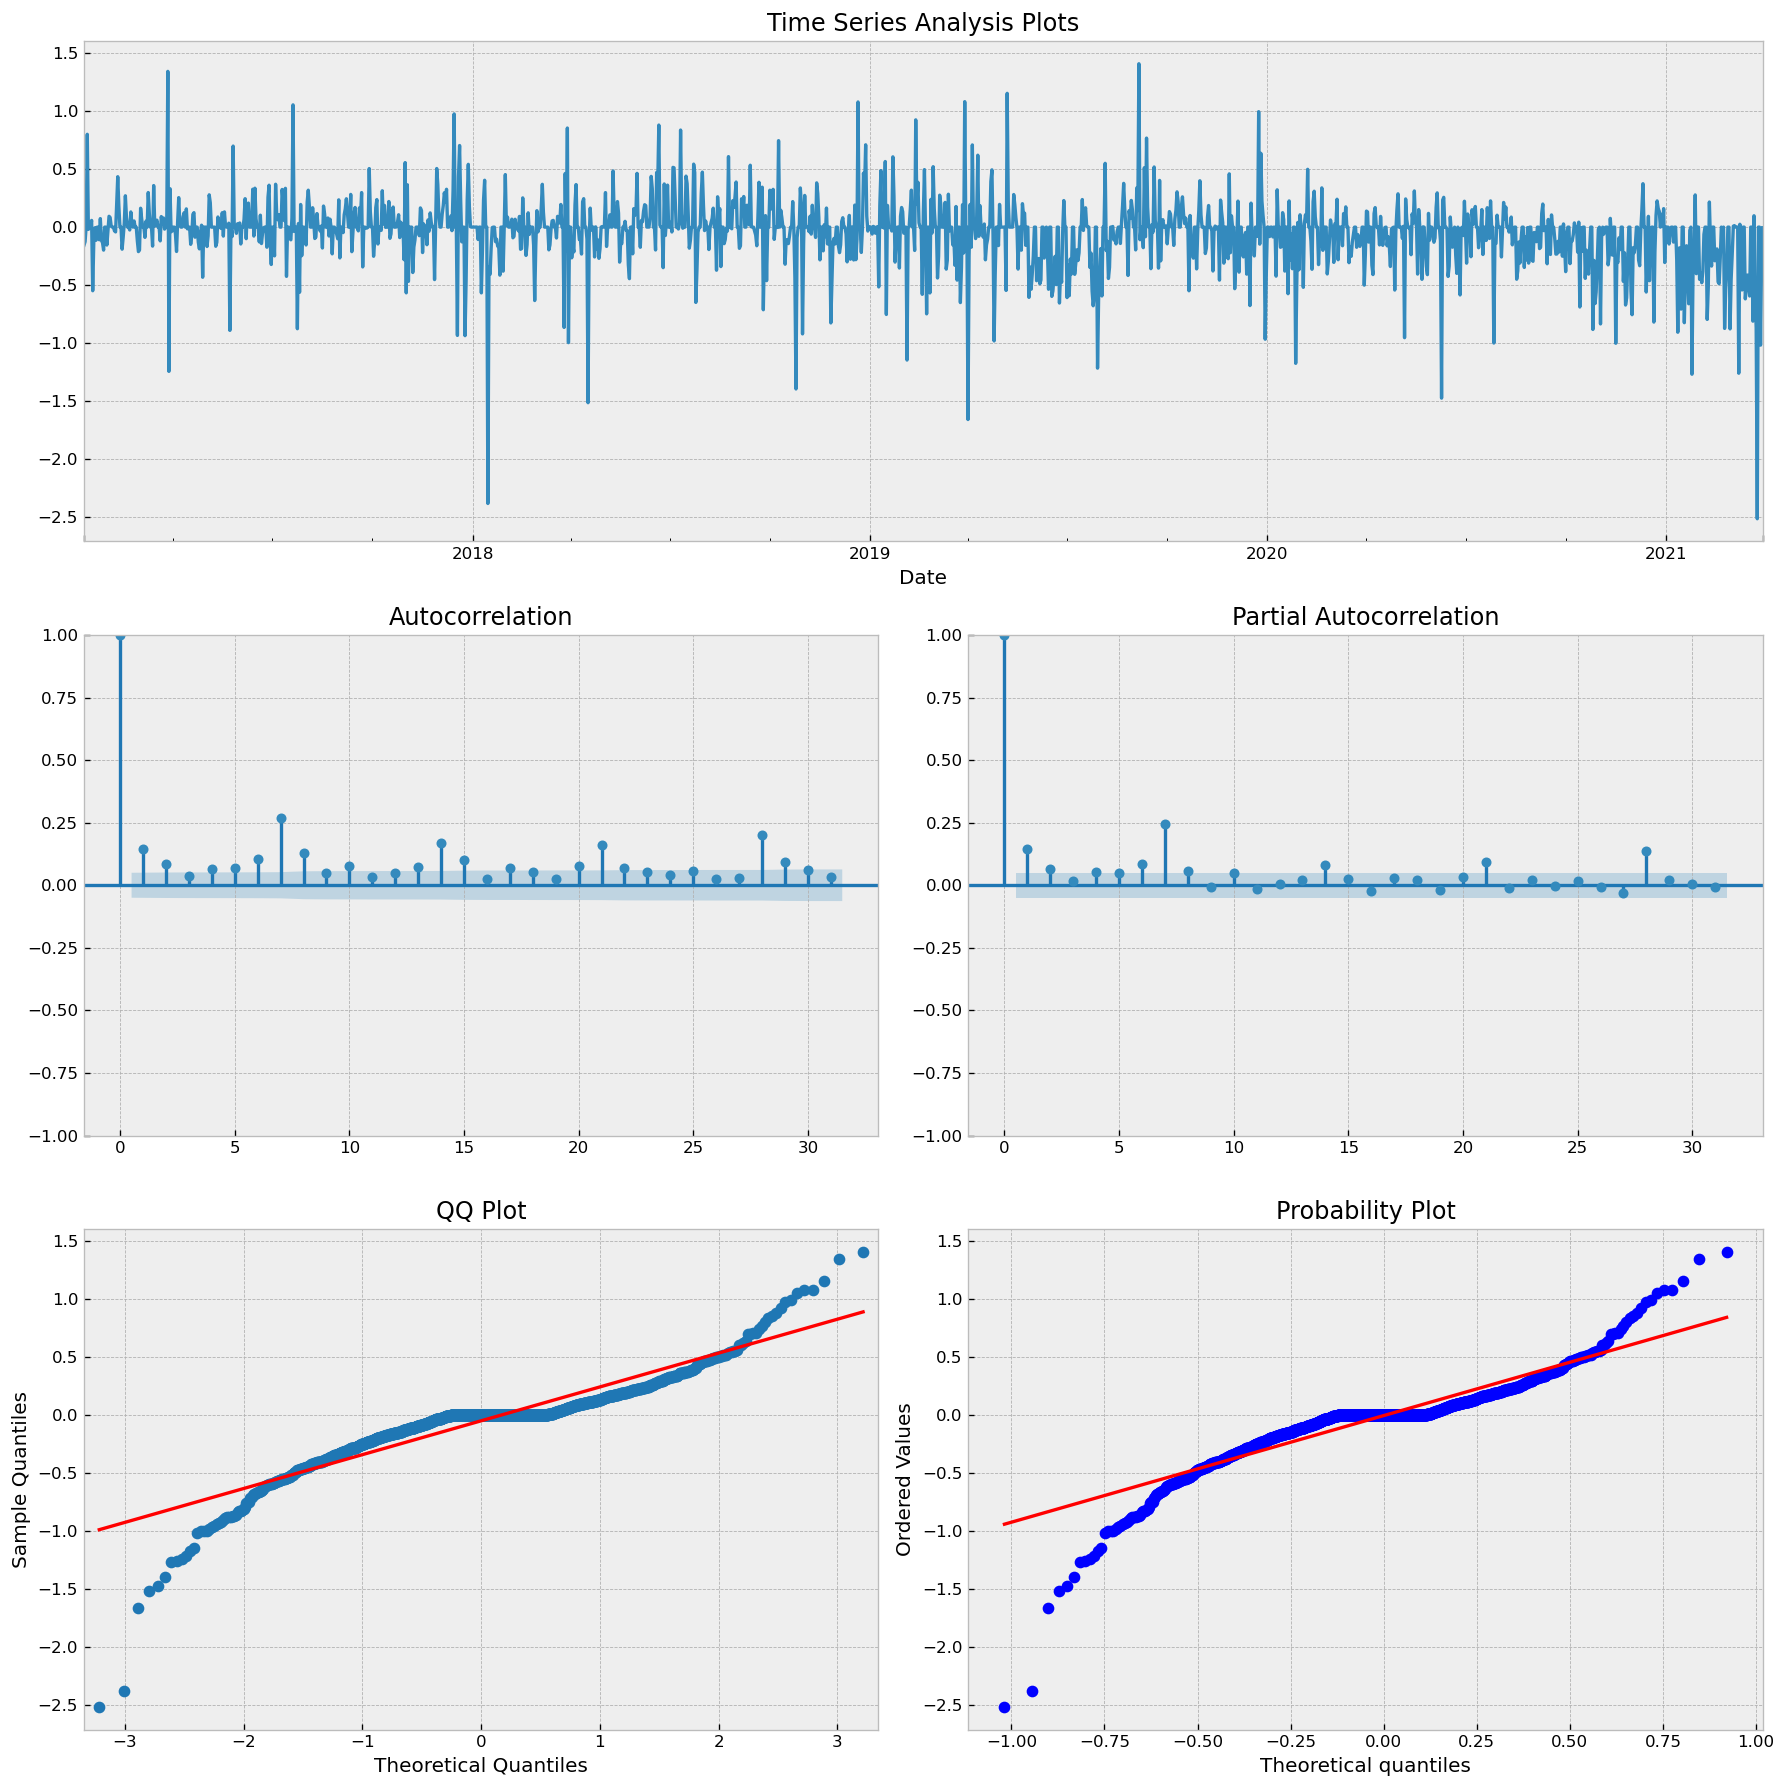

In [201]:
def tsplot(y, lags=None, figsize=(15, 15), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(1)

# plot of discrete white noise
tsplot(df.Balance, lags=31)

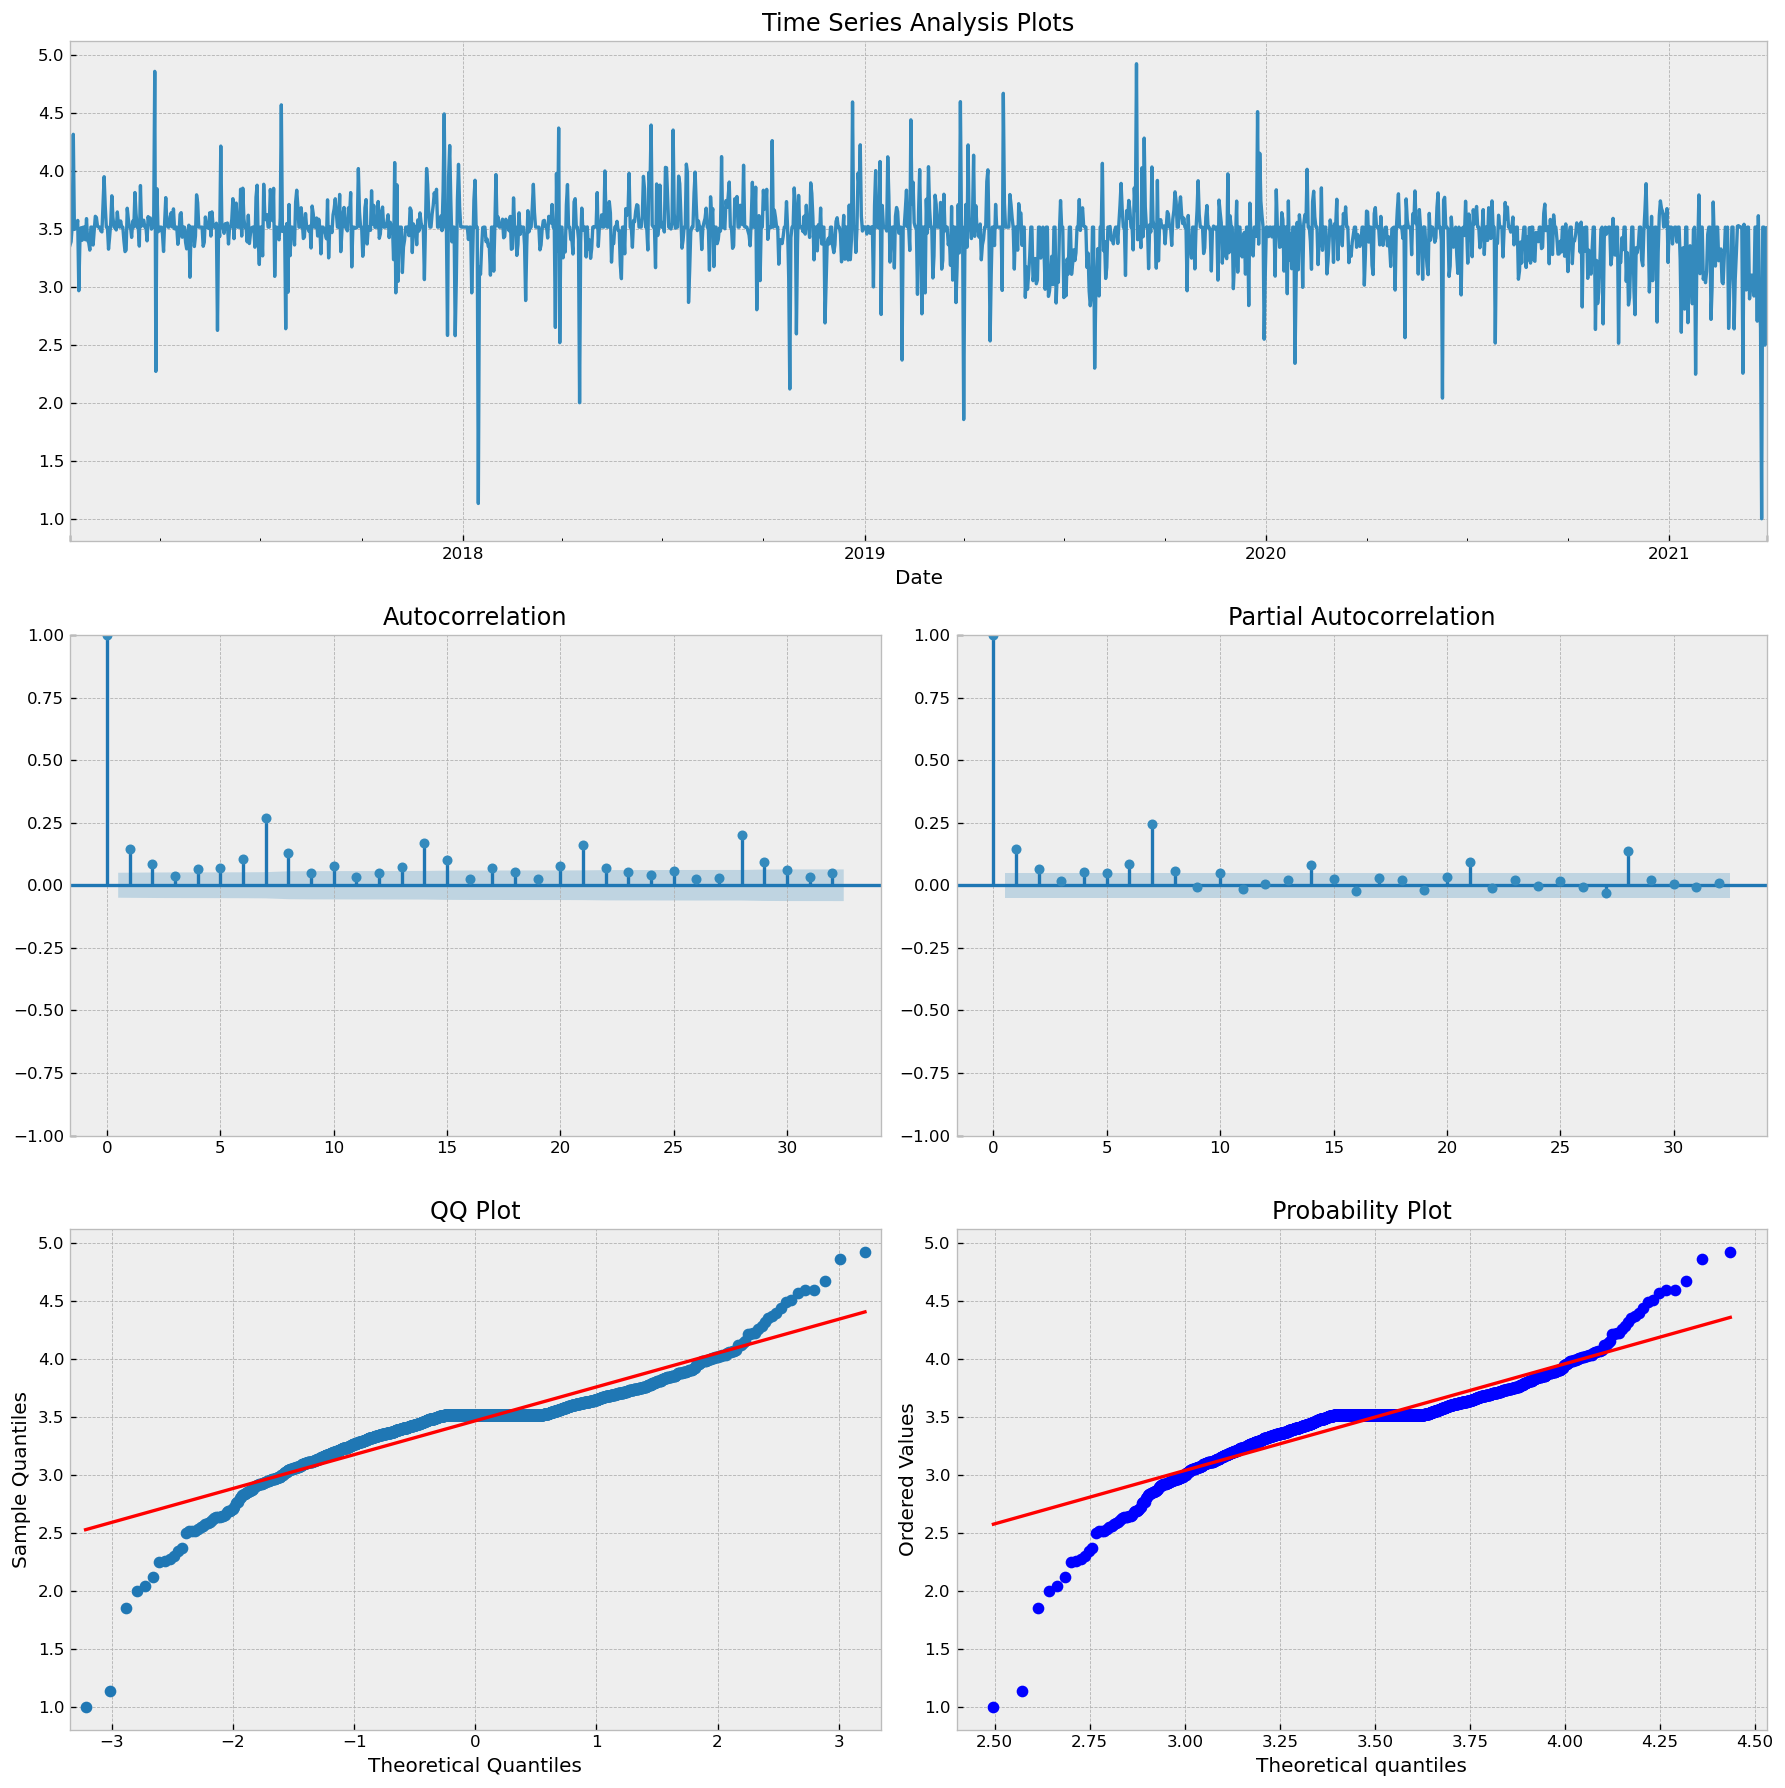

In [202]:
tsplot(df.posBalance)

Похоже на SARIMA(p=1, i=0, q=0, P=1, I=0, Q=0, S=7)

Попробуем избавиться от сезонности дифференцированием

In [203]:
seasonality = 7

df.shift7 = df.posBalance - df.posBalance.shift(7)
df.shift7x2 = df.shift7 - df.shift7.shift(7)

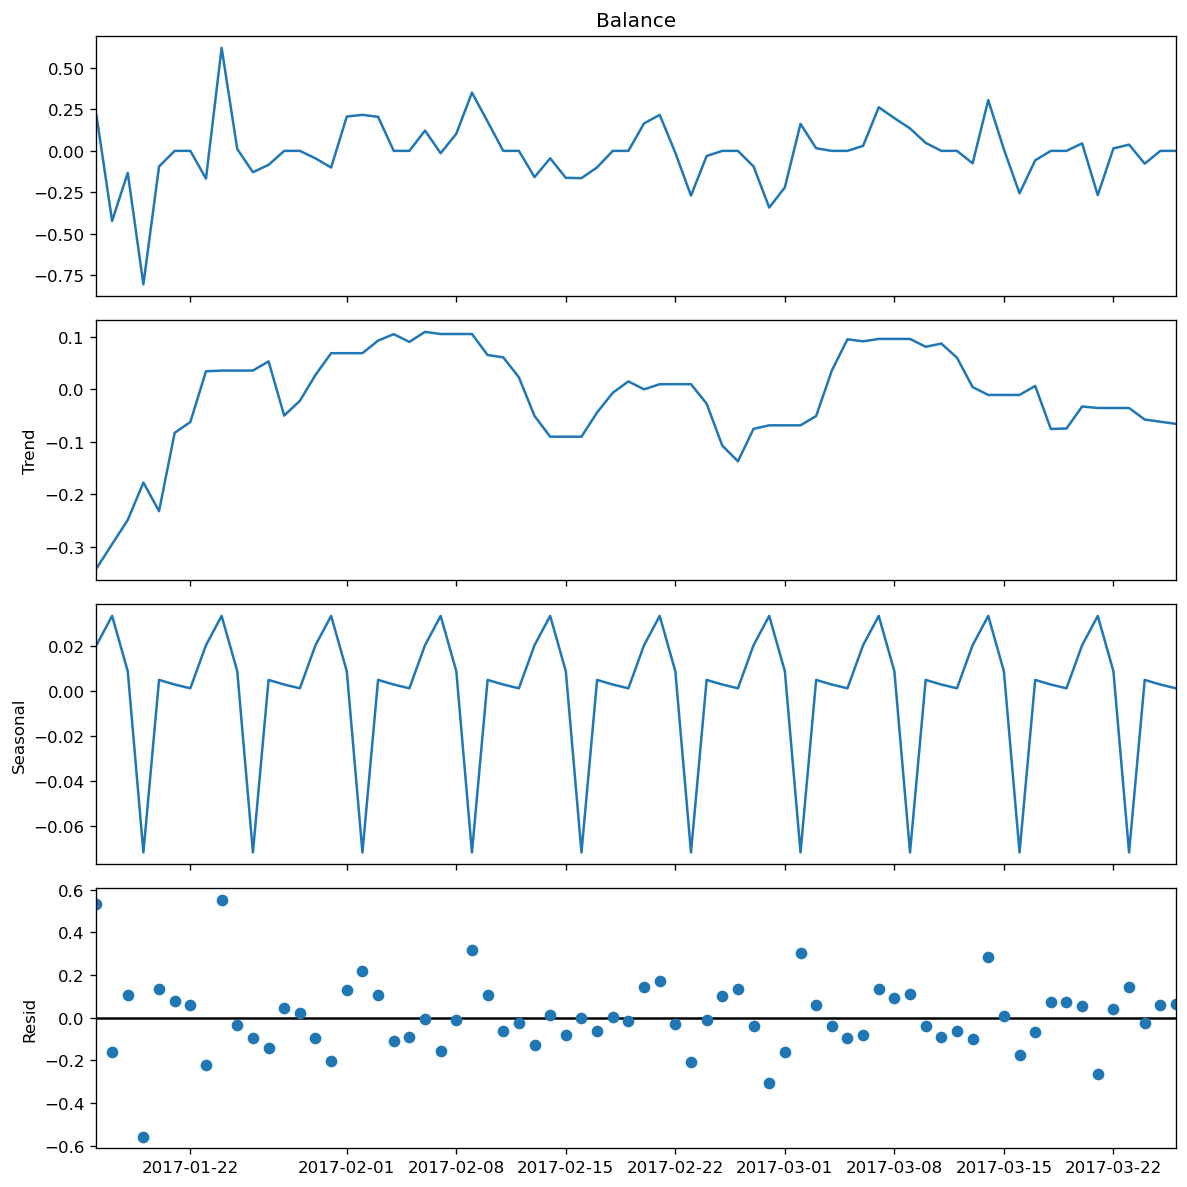

In [204]:
result_add = seasonal_decompose(df.shift7[7:77], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

Вышло так себе

Здесь попытка сделать ряд положительным

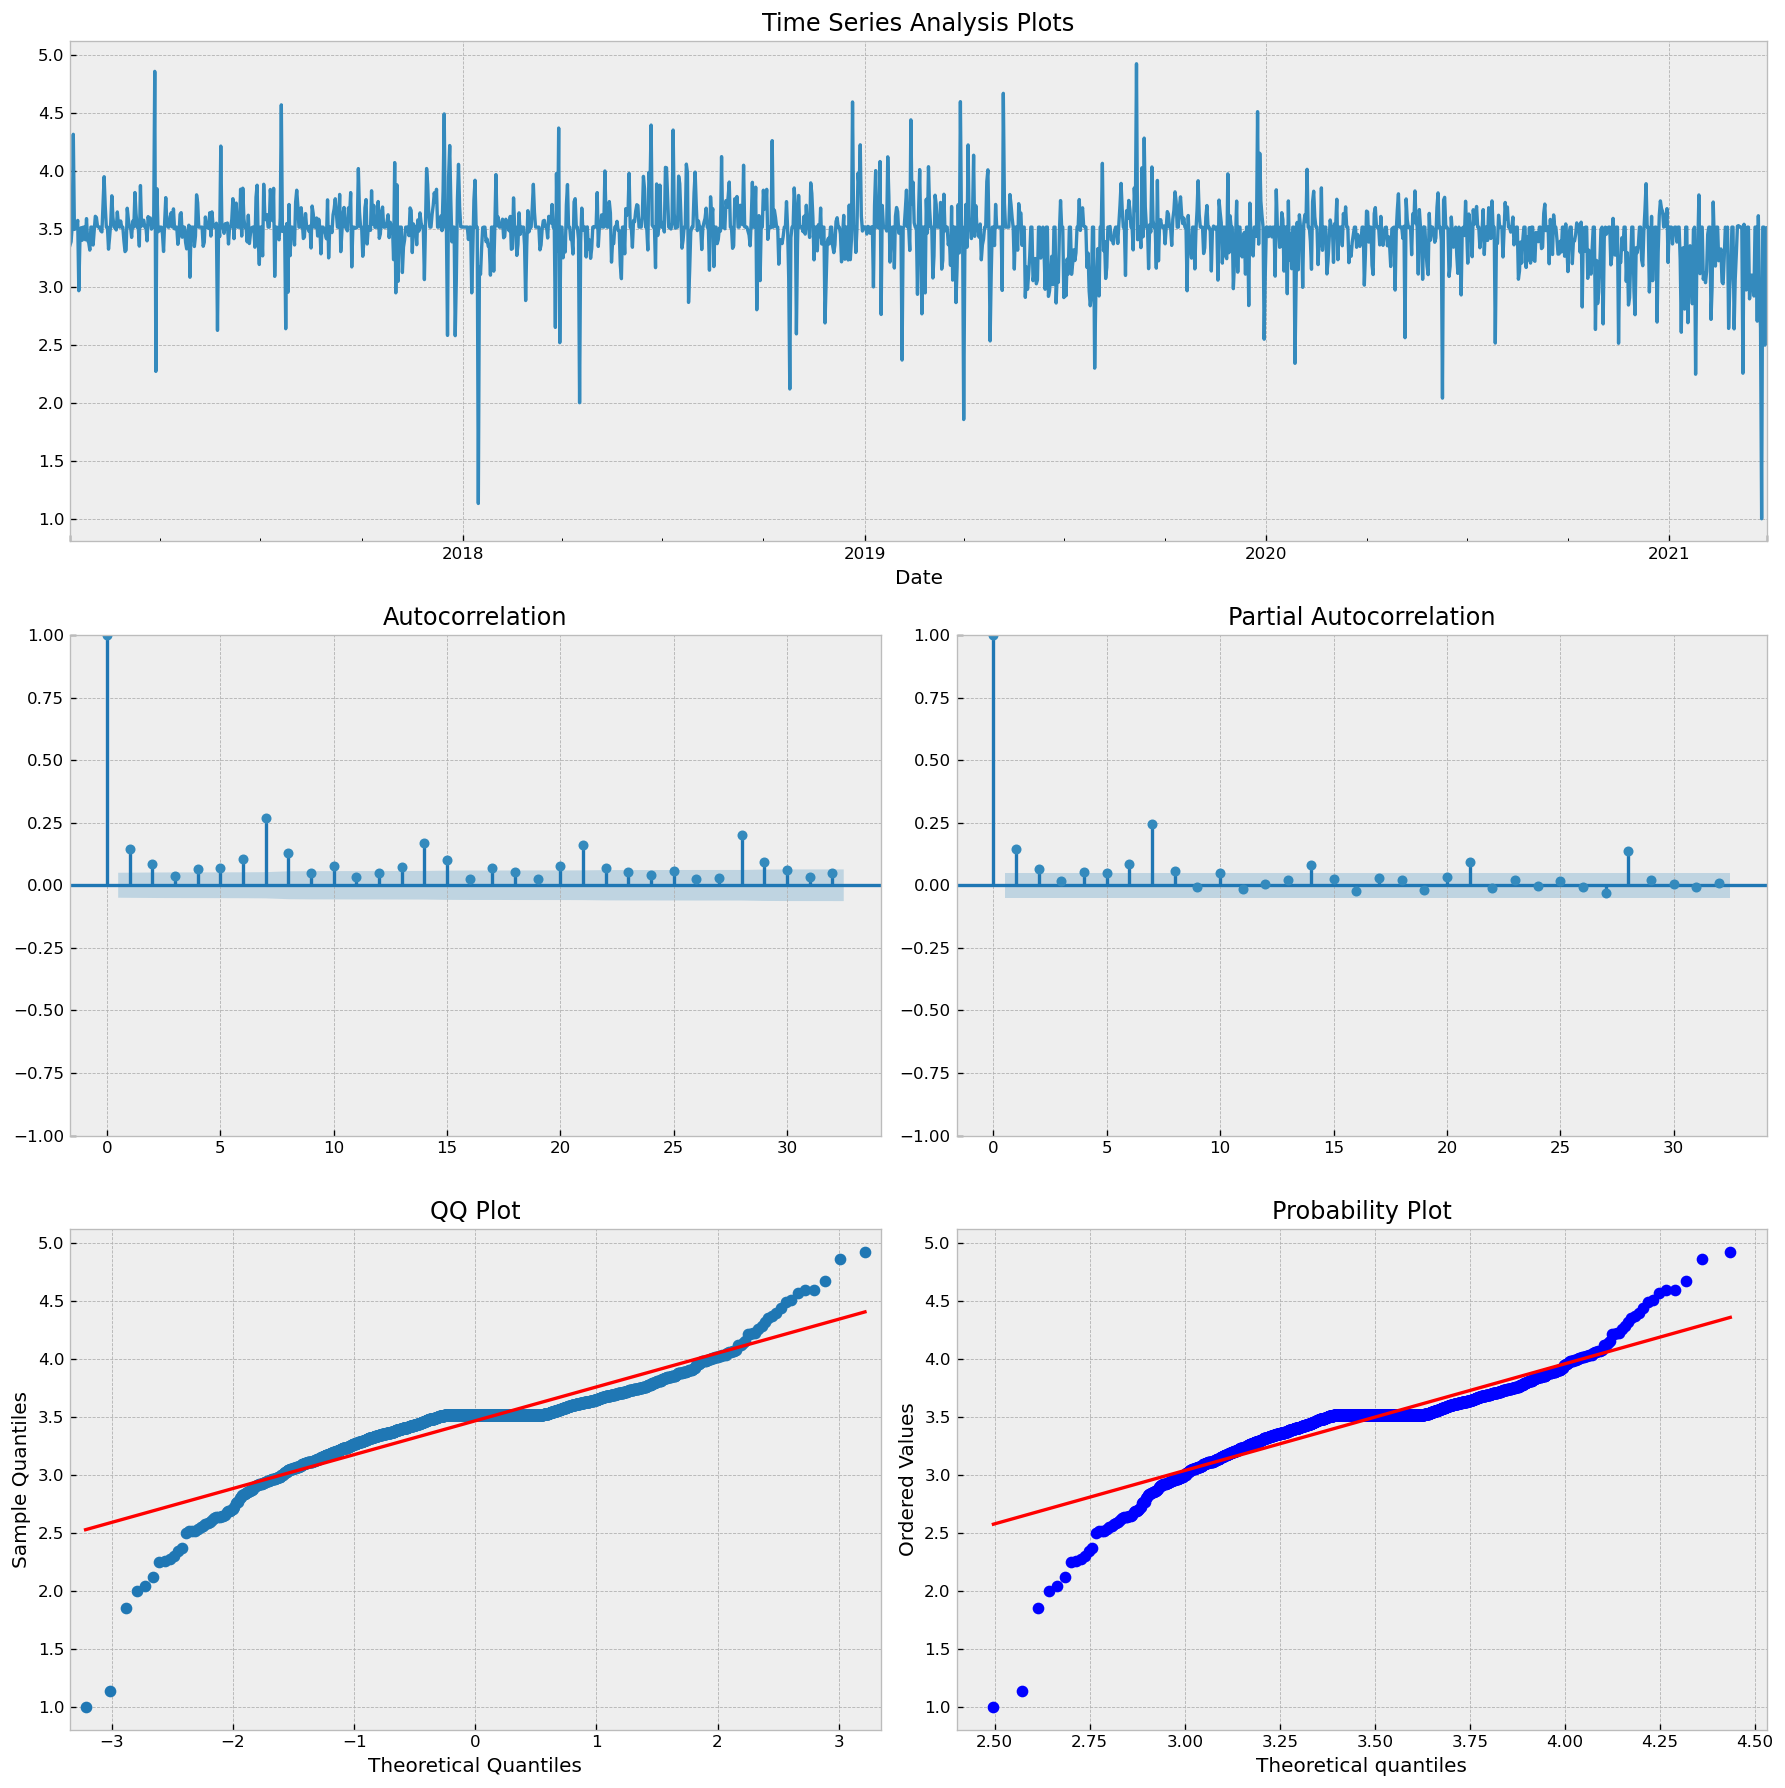

In [205]:
tsplot(df.posBalance)

# Моделирование

In [206]:
start_date = np.datetime64('2017-06-30')
threshold_date = np.datetime64('2020-07-30')
end_date = np.datetime64('2021-01-10')

In [207]:

ps = range(0, 2)
d = 0
qs = range(0, 2)
Ps = range(0, 2)
Ds = range(0, 4)
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Ds, Qs)
parameters_list = list(parameters)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for p, q, P, D, Q in parameters_list:
    try:
        model_SARIMAX = ARIMA(endog=df.Balance[df.index >= threshold_date], order=(p, d, q), seasonal_order=(P, D, Q, 7))
        model_SARIMAX = model_SARIMAX.fit()
    except ValueError:
        print('wrong parameters:', (p,d,q,P,D,Q))
        continue
    mask = (df.index >= threshold_date) & (df.index <= end_date)
    predict=model_SARIMAX.predict(start=threshold_date, end=end_date)
    err_max = (df.Balance[mask]-predict).abs().max()
    err_mean = (df.Balance[mask]-predict).abs().mean()
    aic = model_SARIMAX.aic
    if aic < best_aic:
        best_model = model_SARIMAX
        best_err_max = err_max
        best_err_mean = err_mean
        best_combination = (p,d,q,P,D,Q)
        best_aic = aic
    results.append([p, d, q, P, D, Q, err_max, err_mean, aic])

In [208]:
best_combination

(1, 0, 1, 1, 0, 1)

In [209]:
result_table = pd.DataFrame(results)
result_table.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'err_max', 'err_mean', 'aic']
display(result_table.sort_values(by='aic', ascending=True))

,p,d,q,P,D,Q,err_max,err_mean,aic
57,1,0,1,1,0,1,0.630653,0.137881,73.914688
51,1,0,1,0,1,1,0.624264,0.134110,73.970010
59,1,0,1,1,1,1,0.626335,0.133439,75.244090
41,1,0,0,1,0,1,0.619334,0.139698,76.117666
35,1,0,0,0,1,1,0.672536,0.129339,76.172306
...,...,...,...,...,...,...,...,...,...
52,1,0,1,0,2,0,1.305224,0.280371,363.916221
6,0,0,0,0,3,0,1.738974,0.424673,501.676937
22,0,0,1,0,3,0,1.741338,0.423417,503.385026
38,1,0,0,0,3,0,1.740122,0.423449,503.433382


In [210]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                         Balance   No. Observations:                  245
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                 -30.957
Date:                         Sat, 30 Mar 2024   AIC                             73.915
Time:                                 00:38:38   BIC                             94.922
Sample:                             07-30-2020   HQIC                            82.374
                                  - 03-31-2021                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2047      0.189     -1.086      0.277      -0.574       0.165
ar.L1          0.8912      0.112      7.990      0.000       0.673       1.110
ma.L1         -0.7927      0.140     -5.653      0.000      -1.068      -0.518
ar.S.L7        0.9768      0.029     33.159      0.000       0.919       1.035
ma.S.L7       -0.8508      0.082    -10.366      0.000      -1.012      -0.690
sigma2         0.0736      0.003     23.072      0.000       0.067       0.080
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              2347.29
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               7.13   Skew:                            -2.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [211]:
import pmdarima as pm
model = pm.AutoARIMA(
                        test='adf',
                        start_p=0, end_p=2,
                        # start_d=0, end_d=2,
                        start_q=0, end_q=2,
                        start_P=0, end_P=2,
                        start_D=0, end_D=1,
                        start_Q=0, end_Q=2,
                        m=7,
                        seasonal=True,
                        stationary=True,
                        trace=True
                      ).fit(y=df.Balance[df.index >= threshold_date])

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=132.355, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=94.739, Time=0.12 sec


 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=104.244, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=208.243, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=128.708, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=91.885, Time=0.22 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=76.293, Time=0.75 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=76.118, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=104.760, Time=0.14 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=76.021, Time=0.51 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=99.113, Time=0.25 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=77.928, Time=0.62 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=79.502, Time=0.47 sec
 ARIMA(2,0,0)(1,0,2)[7] intercept   : AIC=77.838, Time=0.55 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=76.305, Time=0.68 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=76.332, Time=0.54 sec
 ARIMA(2,0,1)(1,0,2)[7] intercept   : AIC=78.729, Time=0.74 sec
 ARIMA(1,0,0)(1,0,2)[7]             

In [212]:
mask = (df.index >= threshold_date) & (df.index <= end_date)
predict_auto=model.predict_in_sample(start=threshold_date, end=end_date)
err_auto = (df.Balance[mask]-predict_auto).abs()
print(err_auto.max(), err_auto.mean())

0.642825721313868 0.1399879942019174


In [213]:
mask = (df.index >= threshold_date) & (df.index <= end_date)
predict_chosen = best_model.predict(start=threshold_date, end=end_date)
err_chosen = (df.Balance[mask]-predict_chosen).abs()
print(err_chosen.max(), err_chosen.mean())

0.6306528663571842 0.1378814825846153


<Axes: xlabel='Date', ylabel='predicted_mean'>

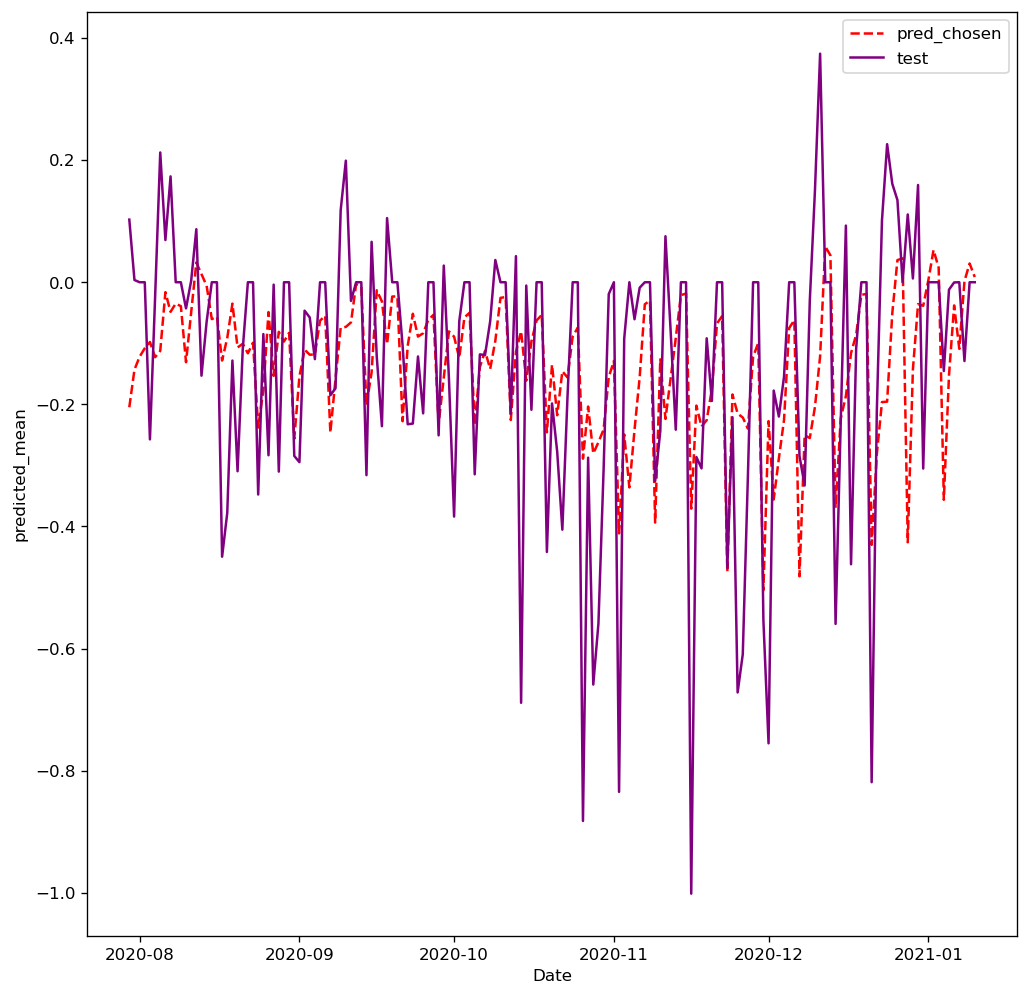

In [214]:
# sns.lineplot(y=df.posBalance[df.index < threshold_date], x=df.index[df.index < threshold_date], label='train')
sns.lineplot(x=df.index[mask], y=predict_chosen, label='pred_chosen', linestyle='dashed', color='red')
sns.lineplot(x=df.index[mask], y=df.Balance[mask], label='test', color = 'purple')

<Axes: xlabel='Date', ylabel='predicted_mean'>

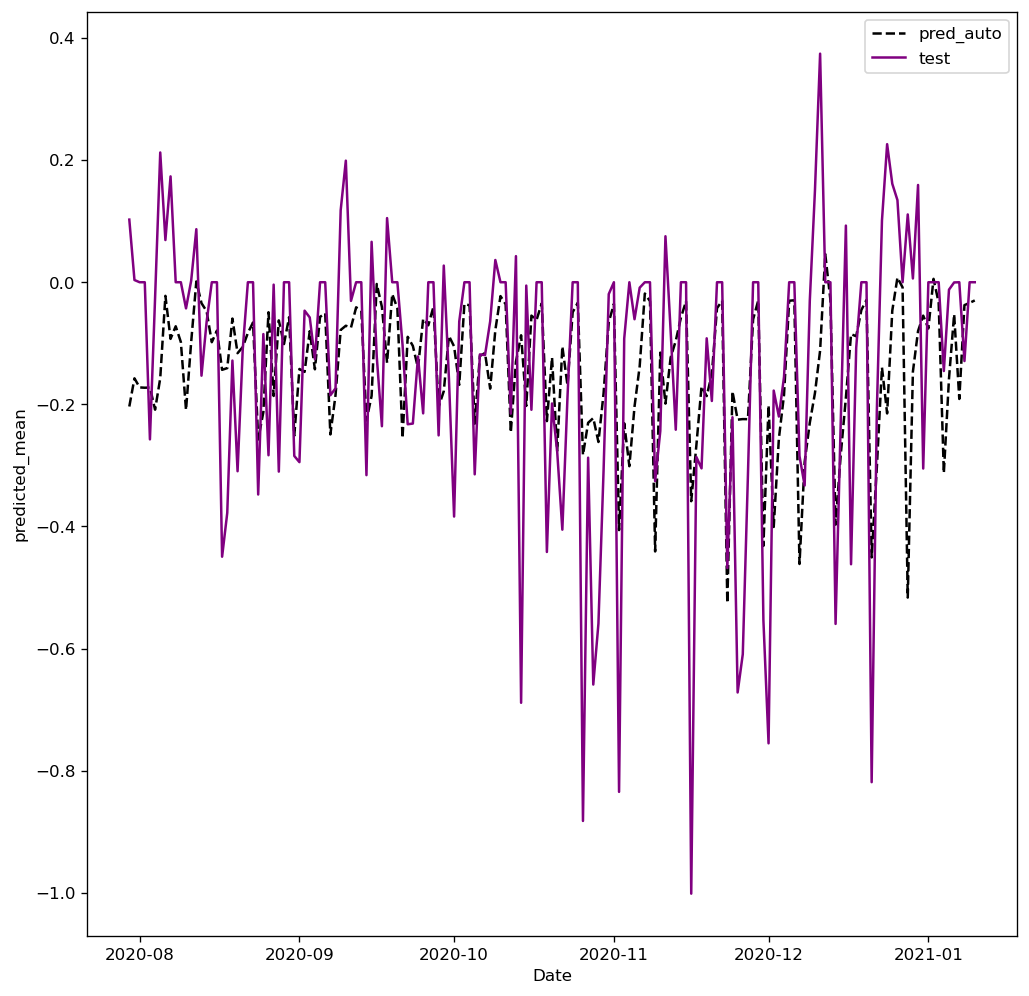

In [215]:
sns.lineplot(x=df.index[mask], y=predict_auto, label='pred_auto', linestyle='dashed', color='black')
sns.lineplot(x=df.index[mask], y=df.Balance[mask], label='test', color = 'purple')

<Axes: xlabel='Date'>

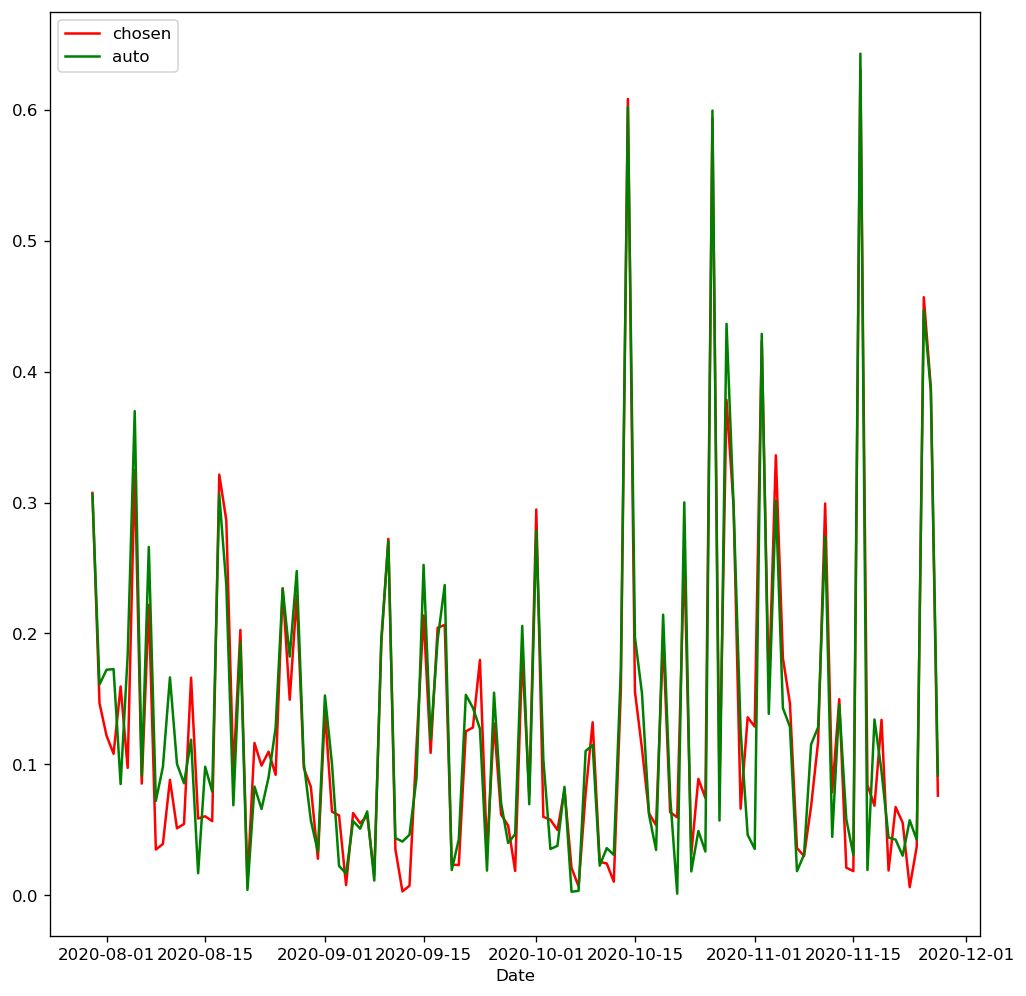

In [216]:
sns.lineplot(x=df.index[mask][:121], y=(df.Balance[mask]-predict_chosen)[:121].abs(), label='chosen', color = 'red')
sns.lineplot(x=df.index[mask][:121], y=(df.Balance[mask]-predict_auto)[:121].abs(), label='auto', color = 'green')

# sns.lineplot(x=df.index[mask][21:], y=df.Balance[mask][21:], label='test', color = 'purple')

### Предположим мы взяли chosen модель

**Посмотрим как ведут себя остатки**

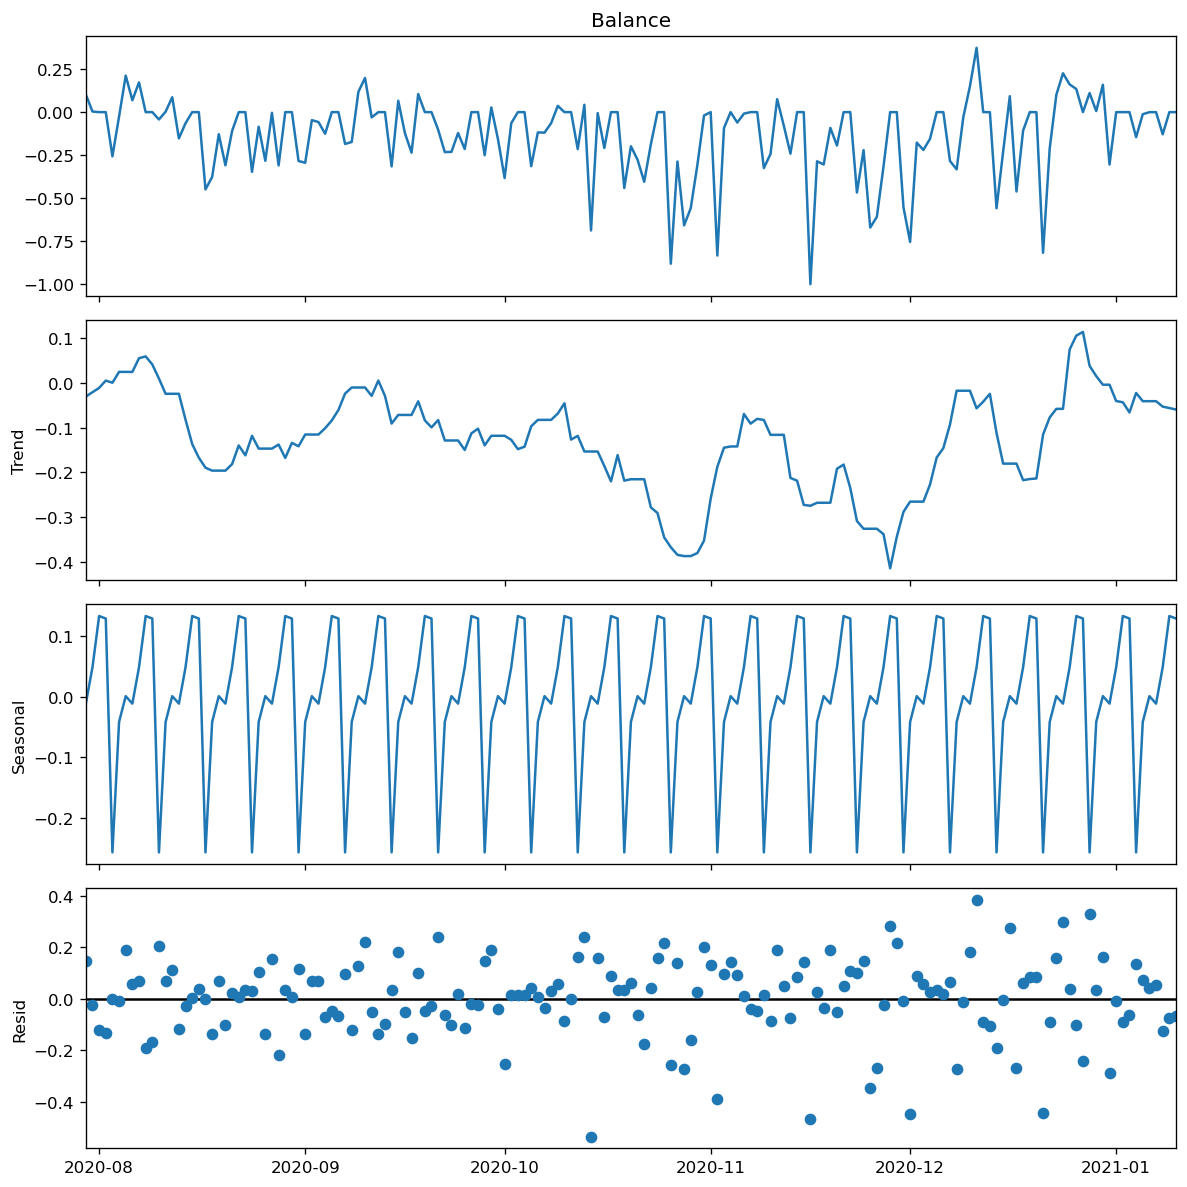

In [217]:
result_add = seasonal_decompose(df.Balance[mask], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

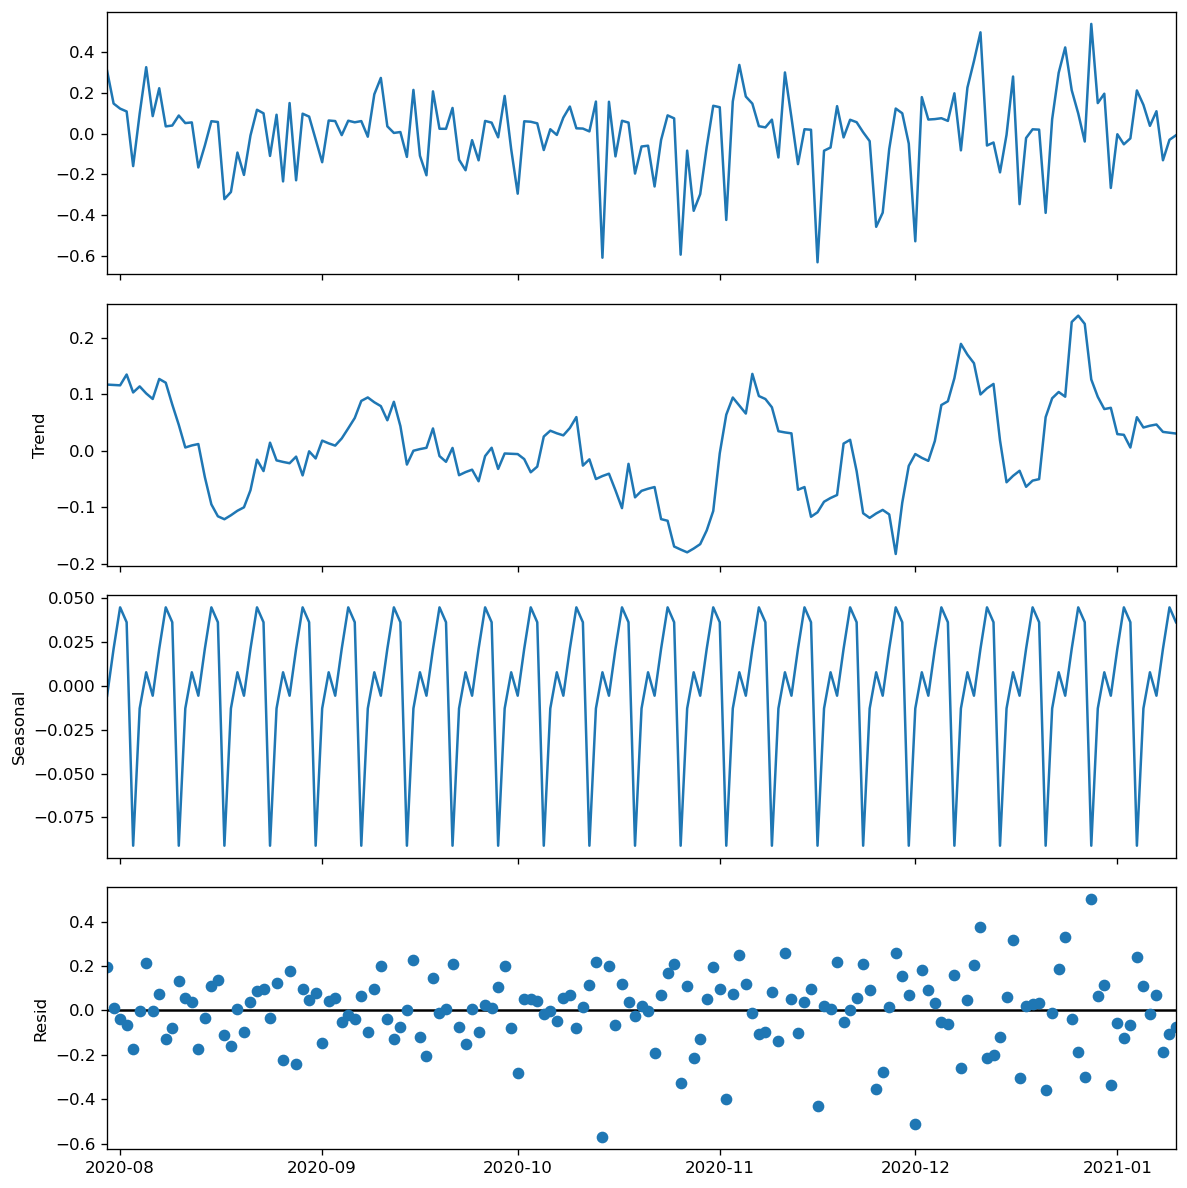

In [218]:
result_add = seasonal_decompose(df.Balance[mask] - predict_chosen, model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

# Попробуем зафигачить фичи дополнительные

# Курс доллара

In [219]:
print(df.index[0], df.index[-1])

2017-01-09 00:00:00 2021-03-31 00:00:00


In [229]:
USD_RUB_df = pd.read_csv(
    "/home/owner/Documents/DEV/Time_series/USD_RUB.csv",
    index_col='Дата', 
    parse_dates=['Дата'],
    usecols=['Дата', 'Цена'],
    )

In [232]:
USD_RUB_df.rename(columns={'Цена' : 'USD'}, inplace=True)

In [239]:
new_df = df.join(USD_RUB_df)
new_df

,Income,Outcome,Balance,USD
Date,,,,
2017-01-09,1.343028,1.487865,-0.155904,"57,5159"
2017-01-10,1.068610,1.194182,-0.125572,NaN
2017-01-11,0.944429,0.936663,0.007767,"58,2807"
2017-01-12,1.672202,0.875379,0.800391,"58,8960"
2017-01-13,0.955924,0.975645,-0.019721,"59,6869"
...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,NaN
2021-03-28,0.000000,0.000000,0.000000,NaN
2021-03-29,2.356883,3.370738,-1.017679,"75,6648"


In [242]:
while not new_df.USD.notna().all():
    new_df.fillna(new_df.shift(1), inplace=True)

In [243]:
new_df

,Income,Outcome,Balance,USD
Date,,,,
2017-01-09,1.343028,1.487865,-0.155904,"57,5159"
2017-01-10,1.068610,1.194182,-0.125572,"57,5159"
2017-01-11,0.944429,0.936663,0.007767,"58,2807"
2017-01-12,1.672202,0.875379,0.800391,"58,8960"
2017-01-13,0.955924,0.975645,-0.019721,"59,6869"
...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,"75,6633"
2021-03-28,0.000000,0.000000,0.000000,"75,6633"
2021-03-29,2.356883,3.370738,-1.017679,"75,6648"


# Праздничные дни

In [245]:
import holidays

In [268]:
all_holidays = pd.to_datetime(np.fromiter(holidays.RU(years=[2017, 2018, 2019, 2020, 2021]).keys(), 'datetime64[ns]'))
all_holidays

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-08', '2017-01-07',
               '2017-02-23', '2017-03-08', '2017-05-01', '2017-05-09',
               '2017-06-12', '2017-11-04', '2018-01-01', '2018-01-02',
               '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06',
               '2018-01-08', '2018-01-07', '2018-02-23', '2018-03-08',
               '2018-05-01', '2018-05-09', '2018-06-12', '2018-11-04',
               '2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-08', '2019-01-07',
               '2019-02-23', '2019-03-08', '2019-05-01', '2019-05-09',
               '2019-06-12', '2019-11-04', '2020-01-01', '2020-01-02',
               '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
               '2020-01-08', '2020-01-07', '2020-02-23', '2020-03-08',
               '2020-05-01', '2020-05-09', '2020-06-12', '2020-11-04',
      

In [269]:
new_df['holiday'] = new_df.index.isin(all_holidays)

In [271]:
new_df.holiday.any()

True

In [272]:
new_df['week_before_holiday'] = new_df.holiday.shift(-1).fillna(False) | \
    new_df.holiday.shift(-2).fillna(False) | new_df.holiday.shift(-3).fillna(False) | \
    new_df.holiday.shift(-4).fillna(False) | new_df.holiday.shift(-5).fillna(False) | \
    new_df.holiday.shift(-6).fillna(False) | new_df.holiday.shift(-7).fillna(False)
        

In [273]:
new_df['day_before_holiday'] = new_df.holiday.shift(-1).fillna(False)

In [304]:
new_df

,Income,Outcome,Balance,USD,holiday,week_before_holiday,day_before_holiday
Date,,,,,,,
2017-01-09,1.343028,1.487865,-0.155904,"57,5159",False,False,False
2017-01-10,1.068610,1.194182,-0.125572,"57,5159",False,False,False
2017-01-11,0.944429,0.936663,0.007767,"58,2807",False,False,False
2017-01-12,1.672202,0.875379,0.800391,"58,8960",False,False,False
2017-01-13,0.955924,0.975645,-0.019721,"59,6869",False,False,False
...,...,...,...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,"75,6633",False,False,False
2021-03-28,0.000000,0.000000,0.000000,"75,6633",False,False,False
2021-03-29,2.356883,3.370738,-1.017679,"75,6648",False,False,False


# Мб еще отдельно обработаем даты

Типо выделим месяцы и заэнкодим мб времена года

In [303]:
test = pd.to_datetime(new_df.index)
test

DatetimeIndex(['2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18',
               ...
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='Date', length=1543, freq=None)